In [1]:
"""
General methodology and structure of code was from me however, 
it was easy to come up with the structure 
as I had learnt from previous xgb versions.
"""

'\nGeneral methodology and structure of code was from me however, \nit was easy to come up with the structure \nas I had learnt from previous xgb versions.\n'

In [2]:
import numpy as np
import pandas as pd
from pyGRNN import GRNN
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline

#8 lines import statements

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#3 lines written by me

In [4]:
"""
Function that loads and prepares the dataframe. 

Converts the data into time-series readable.
"""
def initialFormat (filepath, indicatorcode):
    #Reads the file and creates a dataframe from it
    df = pd.read_excel(filepath)
    
    #Choose what to forecast using indicator code
    df_icode = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df_icode = df_icode.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    #Swap axis so it is in the proper format
    df_formatted = df_icode.swapaxes("index", "columns")
    
    #Renaming column name to 'values' to make reference easier
    for col_names in df_formatted.columns:
        name = df_formatted.rename(columns={col_names : "Val"})
        return name
    
    return df_formatted

#9 Lines written by me

In [5]:
"""
Refactored from: 

https://cprosenjit.medium.com/10-time-series-forecasting-methods-we-should-know-291037d2e285

"""

def shift_dataframe(data):
    #The value in "shift(-x)" is the lookback period in this case 1.
    data["Target"] = data.Val.shift(-1)
    data.dropna(inplace=True)
    
    return data

#4 lines copied from guide

In [6]:
"""
adapted and modified from:
https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37
"""

def train_test_split(data):
    
    train = data[:int(len(data)*0.8)]
    test = data[int(len(data)*0.8):]
    
    return train, test

In [7]:
"""
line 8 in this function used from: 
https://stackoverflow.com/questions/26921651/how-to-delete-the-last-row-of-data-of-a-pandas-dataframe
"""

def mean_imputation(data):
    filled = data.fillna(data.mean())
    filled.drop(data.tail(1).index,inplace=True) #remove last row
    
    return filled

#3 lines written by me

In [8]:
"""
line 9,10,15 (MDA) adapted and modified from: https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9

line 12 (MAPE) adapted from: https://www.statology.org/mape-python/
"""

def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)
    
#13 Lines. 3 From documentation, 1 from github, 9 written by me

In [9]:
"""
Commented out line was the line I used for local testing. Uncommented 'data ='
should be good for universal path

universal path with help from: 

https://stackoverflow.com/questions/50119792/python-import-excel-file-using-relative-path

INDICATOR CODES:

GDP GROWTH = NY.GDP.MKTP.KD.ZG

INFLATION = NY.GDP.DEFL.KD.ZG

UNEMPLOYEMENT MALE = SL.UEM.TOTL.MA.ZS

UNEMPLOYMENT FEMALE = SL.UEM.TOTL.FE.ZS

REAL INTEREST RATE = FR.INR.RINR
"""

#data = initialFormat('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
#                     'NY.GDP.MKTP.KD.ZG')

data = initialFormat(r'./../Indonesia Macro Dataset.xlsx', 'NY.GDP.MKTP.KD.ZG')

filled = mean_imputation(data)
shifted = shift_dataframe(filled)

#Train test and split used for actual training
train, test = train_test_split(shifted)

In [10]:
"Written by me"

X_train = train.Val.values.reshape(-1,1)
y_train = train.Target.values
X_test = test.Val.values.reshape(-1,1)
y_test = test.Target.values

In [11]:
"""
copied from https://github.com/federhub/pyGRNN

"""

IGRNN = GRNN()
params_IGRNN = {'kernel':["RBF"],
                'sigma' : list(np.arange(0.1, 4, 0.01)),
                #'n_splits' : list(np.arange(2,len(X_train),1)),
                'calibration' : ['none'],
                'method' : ['Nelder-Mead']
                 }
grid_IGRNN = GridSearchCV(estimator=IGRNN,
                          param_grid=params_IGRNN,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1
                          )
grid_IGRNN.fit(X_train, y_train)

print("Best hyperparam: ", grid_IGRNN.best_params_)

best_model = grid_IGRNN.best_estimator_
y_pred = best_model.predict(X_test)

#7 lines compied from documentation on github

Fitting 5 folds for each of 390 candidates, totalling 1950 fits
Best hyperparam:  {'calibration': 'none', 'kernel': 'RBF', 'method': 'Nelder-Mead', 'sigma': 1.6499999999999992}


In [12]:
"""
Written by me but just uses function calls to pyGRNN library

two models created, one after hyperparam tuning and this one (line 7,8,9) before hyperparam tuning

Uncomment to test for models before hyperparameter tuning
"""

#model = GRNN(kernel='RBF', calibration='None', seed=42, method='Nelder-Mead',n_splits=10)
#model.fit(X_train, y_train)
#y_pred_b4ht = model.predict(X_test)

'\nWritten by me but just uses function calls to pyGRNN library\n\ntwo models created, one after hyperparam tuning and this one (line 7,8,9) before hyperparam tuning\n\nUncomment to test for models before hyperparameter tuning\n'

In [13]:
dtest = data.fillna(data.mean())
dtest.drop(data.tail(1).index, inplace=True)
newindextest = dtest[int(len(data)*0.8):]
newindex = newindextest.index.values.tolist()

RMSE:  0.5871744203541686
MAPE:  6.979868342642585
MAE:  0.3869681368710576
Scatter Index:  10.872963947073995
MDA:  0.6363636363636364
Mean of actual:  5.400316079519256


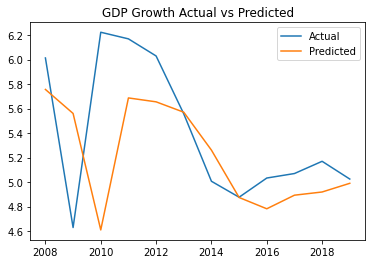

In [14]:
"""
Code written by me, however (line 9) was also used in a previous Introduction to AI Course I partook in,
at City University of London

Link to repository provided: 
https://github.com/LabiKSV/intro-to-ai-farhan-labi/blob/main/Linear%20Regression%20Label%20Encoder.ipynb
"""

df_compare = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
df_compare.index = newindex
df_compare.plot(title='GDP Growth Actual vs Predicted')
performance_metrics(y_test, y_pred)

#5 lines written by me

Text(0.5, 1.0, 'Learning Curve, GRNN Unemployment (F)')

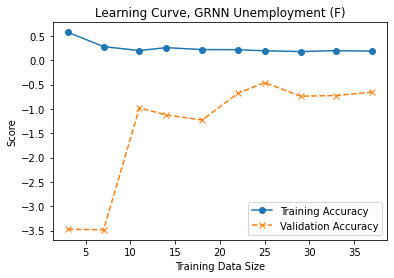

In [15]:
"""
Learning Curve to detect overfit/underfit

Method and code adapted from: 

https://vitalflux.com/learning-curves-explained-python-sklearn-example/amp/
and
https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html#:~:text=Learning%20curves%20can%20be%20generated,see%20in%20the%20following%20examples.
"""

pipeline = make_pipeline(best_model)

train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train,
                                                      y=y_train, cv=5,
                                                      train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, marker='o', label='Training Accuracy')
plt.xlabel('Training Data Size')
plt.plot(train_sizes, test_mean, marker='x', linestyle='--', label='Validation Accuracy')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Learning Curve, GRNN Unemployment (F)')

#14 lines taken directly from guide, integrated with my model


In [16]:
train_mean

array([0.57423153, 0.27925269, 0.19853514, 0.25764489, 0.21824405,
       0.21635067, 0.1929318 , 0.17754829, 0.19648759, 0.18626715])

In [17]:
test_mean

array([-3.47038545, -3.48571705, -0.9791729 , -1.12433914, -1.22904343,
       -0.68054747, -0.45835395, -0.73853097, -0.72571492, -0.65355736])

In [18]:
"""
81 Lines of code
"""

'\n81 Lines of code\n'